### Guided Project:
# Winning Jeopardy

Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for a few decades, and is a major force in popular culture. If you need help at any point, you can consult our solution notebook [here](https://github.com/dataquestio/solutions/blob/master/Mission210Solution.ipynb).<br>

Let's say you want to compete on Jeopardy, and you're looking for any edge you can get to win. In this project, you'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.<br>

The dataset is named `jeopardy.csv`, and contains `20000` rows from the beginning of a full dataset of Jeopardy questions, which you can download [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file). Here's the beginning of the file:

In [133]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

%matplotlib inline

In [134]:
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [135]:
jeopardy.shape

(19999, 7)

As you can see, each row in the dataset represents a single question on a single episode of Jeopardy. Here are explanations of each column:

* `Show Number` -- the Jeopardy episode number of the show this question was in.
* `Air Date` -- the date the episode aired.
* `Round` -- the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
* `Category` -- the category of the question.
* `Value` -- the number of dollars answering the question correctly is worth.
* `Question` -- the text of the question.
* `Answer` -- the text of the answer.

## Jeopardy questions

In [136]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [137]:
columns_nonspace = ['Show Number', 'Air Date', 'Round', 'Category',
                   'Value', 'Question', 'Answer']
col_rename_map = {org:new for (org, new) in zip(jeopardy.columns, columns_nonspace)}

col_rename_map

{' Air Date': 'Air Date',
 ' Answer': 'Answer',
 ' Category': 'Category',
 ' Question': 'Question',
 ' Round': 'Round',
 ' Value': 'Value',
 'Show Number': 'Show Number'}

In [138]:
jeopardy = jeopardy.rename(columns=col_rename_map)
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [139]:
# check data types of each column
for col in jeopardy.columns:
    print(col, '(datatype) :', jeopardy[col].dtype)

Show Number (datatype) : int64
Air Date (datatype) : object
Round (datatype) : object
Category (datatype) : object
Value (datatype) : object
Question (datatype) : object
Answer (datatype) : object


## Normalizing text

Before you can start doing analysis on the Jeopardy questions, you need to normalize all of the text columns (the `Question` and `Answer` columns). We covered normalization before, but the idea is to ensure that you lowercase words and remove punctuation so `Don't` and `don't` aren't considered to be different words when you compare them.

In [140]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    return text

jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)

In [141]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams


## Normalizing columns
Now that you've normalized the text columns, there are also some other columns to normalize.

* The `Value` column **should also be numeric**, to allow you to manipulate it more easily. You'll need to remove the dollar sign from the beginning of each value and convert the column from text to numeric.

* The `Air Date` column **should also be a datetime**, not a string, to enable you to work with it more easily.

In [142]:
jeopardy.Value.unique()

array(['$200', '$400', '$600', '$800', '$2,000', '$1000', '$1200', '$1600',
       '$2000', '$3,200', 'None', '$5,000', '$100', '$300', '$500',
       '$1,000', '$1,500', '$1,200', '$4,800', '$1,800', '$1,100',
       '$2,200', '$3,400', '$3,000', '$4,000', '$1,600', '$6,800',
       '$1,900', '$3,100', '$700', '$1,400', '$2,800', '$8,000', '$6,000',
       '$2,400', '$12,000', '$3,800', '$2,500', '$6,200', '$10,000',
       '$7,000', '$1,492', '$7,400', '$1,300', '$7,200', '$2,600',
       '$3,300', '$5,400', '$4,500', '$2,100', '$900', '$3,600', '$2,127',
       '$367', '$4,400', '$3,500', '$2,900', '$3,900', '$4,100', '$4,600',
       '$10,800', '$2,300', '$5,600', '$1,111', '$8,200', '$5,800', '$750',
       '$7,500', '$1,700', '$9,000', '$6,100', '$1,020', '$4,700',
       '$2,021', '$5,200', '$3,389'], dtype=object)

In [143]:
def normalize_dollar(text):
    try:
        return int(text.replace('$','').replace(',',''))
    except:    
        return 0
    
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_dollar)

In [144]:
jeopardy['clean_value'].unique()

array([  200,   400,   600,   800,  2000,  1000,  1200,  1600,  3200,
           0,  5000,   100,   300,   500,  1500,  4800,  1800,  1100,
        2200,  3400,  3000,  4000,  6800,  1900,  3100,   700,  1400,
        2800,  8000,  6000,  2400, 12000,  3800,  2500,  6200, 10000,
        7000,  1492,  7400,  1300,  7200,  2600,  3300,  5400,  4500,
        2100,   900,  3600,  2127,   367,  4400,  3500,  2900,  3900,
        4100,  4600, 10800,  2300,  5600,  1111,  8200,  5800,   750,
        7500,  1700,  9000,  6100,  1020,  4700,  2021,  5200,  3389])

In [145]:
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

## Answers in questions

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

* How often the answer is deducible from the question.
* How often new questions are repeats of older questions.

You can answer the second question by seeing how often complex words (> 6 characters) reoccur. You can answer the first question by seeing how many times words in the answer also occur in the question. We'll work on the first question now, and come back to the second.

In [147]:
def count_answer_occurring(row):
    
    # Split the clean_answer column on the space character ()
    split_answer = row['clean_answer'].split(' ')
    
    # Split the clean_question column on the space character ()
    split_question = row['clean_question'].split(' ')
    
    match_count = 0
    
    if 'the' in split_answer:
        split_answer.remove('the')
    
    #  This prevents a division by zero error later
    if len(split_answer) == 0:
        return 0
    
    for sp in split_answer:
        if sp in split_question:
            match_count += 1
            
    return match_count / len(split_answer)

jeopardy['answer_in_question'] = jeopardy.apply(count_answer_occurring, axis=1)

In [148]:
# answer_in_question column unique values
jeopardy['answer_in_question'].unique()

array([ 0.        ,  0.33333333,  0.5       ,  0.25      ,  0.2       ,
        0.66666667,  1.        ,  0.28571429,  0.4       ,  0.6       ,
        0.16666667,  0.75      ,  0.57142857,  0.14285714,  0.375     ,
        0.30769231,  0.15384615,  0.125     ,  0.3       ,  0.1       ,
        0.42857143,  0.44444444,  0.11111111,  0.18181818,  0.27272727,
        0.875     ,  0.22222222,  0.8       ])

In [149]:
# mean of answer_in_question column
jeopardy['answer_in_question'].mean()

0.060493257069335872

In [150]:
# observation probability of answer occurring in question
jeopardy[jeopardy['answer_in_question'] != 0].shape[0] / jeopardy.shape[0]

0.1312065603280164

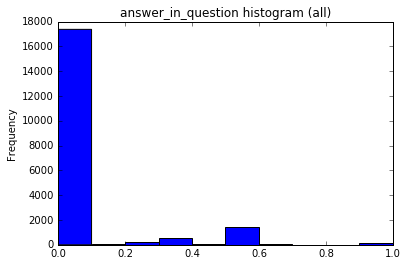

In [151]:
plt.title('answer_in_question histogram (all)')
jeopardy['answer_in_question'].plot(kind='hist')
plt.show()

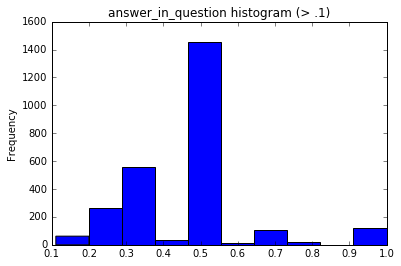

In [152]:
plt.title('answer_in_question histogram (> .1)')
jeopardy['answer_in_question'][jeopardy['answer_in_question']>0.1].plot(kind='hist')
plt.show()

### Note
* Observation probability for occurring answer in each word of question
  * 0.06
  
* Observation probability for answer occurred in question
  * 0.13

## Recycled questions

Let's say you want to investigate **how often new questions are repeats of older ones**. You can't completely answer this, because you only have about `10%` of the full Jeopardy question dataset, but you can investigate it at least.<br>

To do this, you can:

* Sort `jeopardy` in order of ascending air date.
* Maintain a set called `terms_used` that will be empty initially.
* Iterate through each row of `jeopardy`.
* Split `clean_question` into words, remove any word shorter than 6 characters, and check if each word occurs in `terms_used`.
  * If it does, increment a counter.
  * Add each word to `terms_used`.

This will enable you to check if the terms in questions have been used previously or not. Only looking at words greater than `6` characters enables you to filter out words like `the` and `than`, which are commonly used, but don't tell you a lot about a question.

In [153]:
# unique lengths of clean answers
jeopardy['clean_answer'].apply(lambda x: len(x)).unique()

array([ 10,   7,   9,  14,  13,  19,  12,   6,  11,   3,  17,  50,  18,
        16,   2,   5,   8,  26,  15,   4,  21,  28,  22,  27,  20,  30,
        55,  23,   1,  24,  29,  35,  25,  37,  36,  32,  45,  38,  33,
        31,  52,  34,  42,  81,  39,  60,  44,  41,  56,  40,  43,  47,
        46,  64,  54,  59,  57,  49,  75,  48,  51,  70,  62,  67, 126,
        61,  69])

In [154]:
jeopardy = jeopardy.sort_values(by='Air Date')

In [160]:
question_overlap = []
terms_used = set()
for i, row in jeopardy.iterrows():
        
        split_question = row["clean_question"].split(" ")
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        
        for word in split_question:
            if word in terms_used:
                match_count += 1
        
        for word in split_question:
            terms_used.add(word)
        
        if len(split_question) > 0:
            match_count /= len(split_question)
        
        question_overlap.append(match_count)

jeopardy["question_overlap"] = question_overlap
jeopardy["question_overlap"].mean()

0.68762605921698017

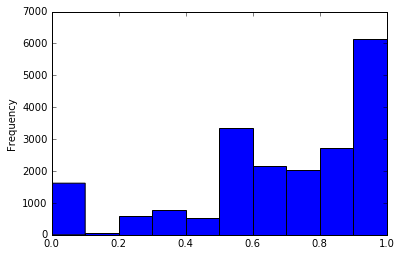

In [161]:
jeopardy['question_overlap'].plot(kind='hist'); plt.show()

In [162]:
jeopardy['Air Year'] = jeopardy['Air Date'].apply(lambda x: x.year)

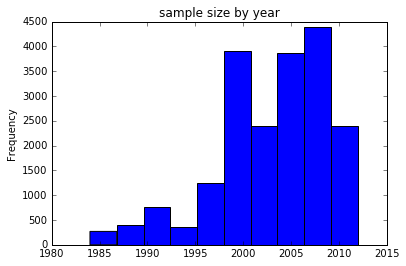

In [163]:
plt.title('sample size by year')
jeopardy['Air Year'].plot(kind='hist', bins=10)

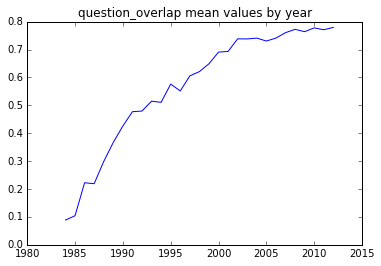

In [164]:
mean_question_overlap_by_year = []

for year in jeopardy['Air Year'].unique():
    
    mean_by_year = jeopardy['question_overlap'][jeopardy['Air Year']==year].mean()
    mean_question_overlap_by_year.append(mean_by_year)

plt.title('question_overlap mean values by year')
plt.plot(range(min(jeopardy['Air Year']), max(jeopardy['Air Year'])+1),\
         mean_question_overlap_by_year); plt.show()

### Note 2
`jeopardy['question_overlap'].mean()`
**Does it mean for questions being recycled?**

> **NOT sure, but worth digging into.**

* We do not consider phrases but only words.
* `question_overlap` value rises as time being passed.
* However, even if we limit the length over 6 characters, the accumulative way to gather term/word itself may cause the overall overlaps by time, at some degree.

## Low value vs. high value questions


Let's say **you only want to study questions that pertain to high value questions instead of low value questions**. This will help you earn more money when you're on Jeopardy.<br>

You can actually figure out which terms correspond to high-value questions using a chi-squared test. You'll first need to narrow down the questions into two categories:

* Low value -- Any row where `Value` is less than `800`.
* High value -- Any row where `Value` is greater than `800`.

You'll then be able to loop through each of the terms from the last screen, `terms_used`, and:

* Find the number of low value questions the word occurs in.
* Find the number of high value questions the word occurs in.
* Find the percentage of questions the word occurs in.
* Based on the percentage of questions the word occurs in, find expected counts.
* Compute the chi squared value based on the expected counts and the observed counts for high and low value questions.

You can then find the words with the biggest differences in usage between high and low value questions, by selecting the words with the highest associated chi-squared values. Doing this for all of the words would take a very long time, so we'll just do it for a small sample now.

In [165]:
def determine_high_val(row):

    if row['clean_value'] > 800: return 1
    else: return 0

jeopardy['high_value'] = jeopardy.apply(determine_high_val, axis=1)
jeopardy['high_value'].unique()    

array([0, 1])

In [166]:
def count_highlow(word):
    
    low_count = 0
    high_count = 0
    
    for idx, row in jeopardy.iterrows():
        
        clean_question_split = row['clean_question'].split(' ')
        
        if word in clean_question_split:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1

    return high_count, low_count

In [167]:
observed_expected = []

terms_used = list(terms_used)
comparison_terms = terms_used[:5]

for term in comparison_terms:
    
    observed_expected.append(count_highlow(term))

In [168]:
comparison_terms

['ornament', 'quarantines', 'ionizing', 'diseaseprone', 'nutmeg']

In [169]:
observed_expected

[(0, 2), (0, 1), (1, 0), (0, 1), (0, 2)]

## Applying the chi-squared test

In [170]:
high_value_count = jeopardy[jeopardy['high_value']==1].shape[0]
low_value_count = jeopardy[jeopardy['high_value']==0].shape[0]

In [171]:
print(high_value_count, low_value_count)

5734 14265


In [172]:
from scipy.stats import chisquare

In [173]:
chi_squared = []

for high, low in observed_expected:
    
    total = high + low
    total_prop = total / jeopardy.shape[0]
    
    expected_high_value_count = total_prop * high_value_count
    expected_low_value_count = total_prop * low_value_count
    
    chi, pval = chisquare([high, low],
                                  [expected_high_value_count, expected_low_value_count])
    
    chi_squared.append((chi, pval))

In [174]:
chi_squared

[(0.80392569225376798, 0.36992223780795708),
 (0.40196284612688399, 0.52607729857054686),
 (2.4877921171956752, 0.11473257634454047),
 (0.40196284612688399, 0.52607729857054686),
 (0.80392569225376798, 0.36992223780795708)]